**Predict Closed Questions on StackOverflow**

**Group Members:** <br>
Nermeen Soliman - 19104699 <br>
Seifeldin Sami - 19106471 <br>
Mirna Ahmed - 19104977 <br>

**Project Description:**

Programmers ask many questions on Stack Overflow all the time, some are great, others are repetitive, time-wasting, or incomplete. So, in this project, you want to predict whether a new question will be closed or not, along with the reason why.

# Imports for Cleaning Dataset

In [3]:
!pip install git+https://github.com/jbesomi/texthero.git -qq

In [4]:
import json
import time
import os
import shutil
import pandas as pd
import numpy as np
import zipfile
import texthero as hero
from nltk.corpus import stopwords
import nltk
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt

In [5]:
# Download the NLTK stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Uploading Dataset

In [6]:
file_path = '/kaggle/input/predict-closed-questions-on-stack-overflow/train-sample.csv'
# Load the CSV file
data = pd.read_csv(file_path, sep=',', on_bad_lines='skip')

In [7]:
data.shape

(140272, 15)

In [8]:
data.OpenStatus.value_counts()

open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: OpenStatus, dtype: int64

In [9]:
data.head()

PostId     PostCreationDate  OwnerUserId    OwnerCreationDate  \
0   6046168  05/18/2011 14:14:05       543315  09/17/2010 10:15:06   
1   4873911  02/02/2011 11:30:10       465076  10/03/2010 09:30:58   
2   3311559  07/22/2010 17:21:54       406143  07/22/2010 16:58:20   
3   9990413  04/03/2012 09:18:39       851755  07/19/2011 10:22:40   
4  10421966  05/02/2012 21:25:01       603588  02/04/2011 18:05:34   

   ReputationAtPostCreation  OwnerUndeletedAnswerCountAtPostTime  \
0                         1                                    2   
1                       192                                   24   
2                         1                                    0   
3                         4                                    1   
4                       334                                   14   

                                               Title  \
0  For Mongodb is it better to reference an objec...   
1  How to insert schemalocation in a xml document...   
2                            Too many lookup tables    
3                    What is this PHP code in VB.net   
4  Spring-Data mongodb querying multiple classes ...   

                                        BodyMarkdown        Tag1  \
0  I am building a corpus of indexed sentences in...     mongodb   
1  i create a xml document with JAXP and search a...         dom   
2  What are the adverse effects of having too man...  sql-server   
3  I am looking for the vb.net equivalent of this...         php   
4  With Spring-Data, you can use the @Document an...     mongodb   

              Tag2   Tag3 Tag4 Tag5       PostClosedDate     OpenStatus  
0              NaN    NaN  NaN  NaN                  NaN           open  
1              xsd   jaxp  NaN  NaN                  NaN           open  
2  database-design  enums  NaN  NaN                  NaN           open  
3           vb.net    NaN  NaN  NaN  04/15/2012 21:12:48  too localized  
4      spring-data    NaN  NaN  NaN                  NaN           open

In [10]:
# Let's take 'TITLE' & 'BODYMARKDOWN' & OpenStatus Columns
data = data[['Title', 'BodyMarkdown', 'OpenStatus']]
data.head()

Title  \
0  For Mongodb is it better to reference an objec...   
1  How to insert schemalocation in a xml document...   
2                            Too many lookup tables    
3                    What is this PHP code in VB.net   
4  Spring-Data mongodb querying multiple classes ...   

                                        BodyMarkdown     OpenStatus  
0  I am building a corpus of indexed sentences in...           open  
1  i create a xml document with JAXP and search a...           open  
2  What are the adverse effects of having too man...           open  
3  I am looking for the vb.net equivalent of this...  too localized  
4  With Spring-Data, you can use the @Document an...           open

In [11]:
data.shape

(140272, 3)

# Preprocessing Dataset

In [12]:
data['Text'] = data['Title'] + ' ' + data['BodyMarkdown']

In [13]:
data = data.drop(columns = ['Title', 'BodyMarkdown'])

In [14]:
data.head(5)

OpenStatus                                               Text
0           open  For Mongodb is it better to reference an objec...
1           open  How to insert schemalocation in a xml document...
2           open  Too many lookup tables  What are the adverse e...
3  too localized  What is this PHP code in VB.net I am looking f...
4           open  Spring-Data mongodb querying multiple classes ...

In [15]:
import texthero.preprocessing as preprocessing

# Define a custom pipeline for preprocessing
custom_pipeline = [
    preprocessing.fillna,                   # Fill NaN values
    preprocessing.lowercase,                # Convert to lowercase
    preprocessing.remove_whitespace,        # Remove leading/trailing whitespace
    preprocessing.remove_punctuation,       # Remove punctuation
    preprocessing.remove_diacritics,        # Remove diacritics
]

In [16]:
# Let's pre process the data using library called "Text_hero"
data['Text'] = hero.clean(data['Text'])

/usr/local/lib/python3.10/site-packages/texthero/preprocessing.py:105: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(pattern, symbols)
/usr/local/lib/python3.10/site-packages/texthero/preprocessing.py:661: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(pattern, "")
/usr/local/lib/python3.10/site-packages/texthero/preprocessing.py:173: FutureWarning: The default value of regex will change from True to False in a future version.
  return s.str.replace(rf"([{string.punctuation}])+", symbol)


In [17]:
data.head()

OpenStatus                                               Text
0           open  mongodb better reference object use natural st...
1           open  insert schemalocation xml document via dom cre...
2           open  many lookup tables adverse effects many lookup...
3  too localized  php code vb net looking vb net equivalent func...
4           open  spring data mongodb querying multiple classes ...

In [18]:
data.OpenStatus.value_counts()

open                   70136
not a real question    30789
off topic              17530
not constructive       15659
too localized           6158
Name: OpenStatus, dtype: int64

In [19]:
data['id'] = range(len(data))

# Data Visualization

In [20]:
!pip install -qq plotly wordcloud

In [21]:
import plotly.express as px
from plotly.offline import init_notebook_mode
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

In [22]:
fig = px.pie(data, values='id', names='OpenStatus', height=600, title='Classification of Questions')
fig.show()

In [23]:
data['Text_Length'] = data['Text'].apply(lambda x: len(x.split()))

In [24]:
px.histogram(data, x="Text_Length", height=700, color='OpenStatus', title="Text Length Distribution", marginal="box")

In [25]:
Text = data['Text'].tolist()

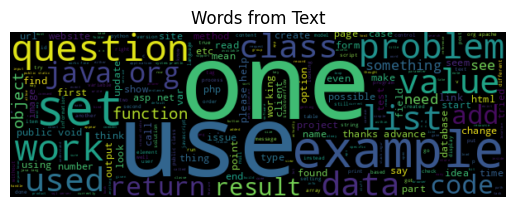

In [26]:
wordcloud = WordCloud(max_words=1500, width=600, background_color='black').generate(" ".join(Text))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Words from Text")
plt.axis("off")
plt.show()

In [27]:
del Text

# Train Test Split

In [28]:
label_id = {'open': 0, 'not a real question': 1, 'off topic': 2, 'not constructive': 3, 'too localized': 4}

In [29]:
data['OpenStatus']= data['OpenStatus'].map(label_id)

In [30]:
data.head()

OpenStatus                                               Text  id  \
0           0  mongodb better reference object use natural st...   0   
1           0  insert schemalocation xml document via dom cre...   1   
2           0  many lookup tables adverse effects many lookup...   2   
3           4  php code vb net looking vb net equivalent func...   3   
4           0  spring data mongodb querying multiple classes ...   4   

   Text_Length  
0           48  
1           64  
2           17  
3           97  
4           63

In [31]:
train_main, remaining_data = train_test_split(data, test_size=0.30, shuffle=True, random_state=203, stratify=data['OpenStatus'])
val_main, test_main = train_test_split(remaining_data, test_size=0.3333, shuffle=True, random_state=203, stratify=remaining_data['OpenStatus'])

# Modeling

In [32]:
!pip -qq install transformers

In [33]:
import tensorflow as tf
from transformers import AutoTokenizer,TFBertModel
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input,GlobalAveragePooling1D,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import os

/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [34]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [35]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print(1)
    tf.config.experimental_connect_to_cluster(tpu)
    print(2)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    print(3)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print(4)
    BATCH_SIZE = strategy.num_replicas_in_sync * 4
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 32
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")  


1
2
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local


2024-05-31 20:30:02.407829: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.407947: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.408037: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.408111: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.408199: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.408460: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:02.408564: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

INFO:tensorflow:Finished initializing TPU system.


3
INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


4
Running on TPU: 
Batch Size: 32


In [36]:
model_check='bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_check)

In [37]:
def encode_text(text, tokenizer):
    encoded = tokenizer.batch_encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,#gui code
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="tf",
    )
    input_ids = np.array(encoded["input_ids"], dtype="int32")
    attention_masks = np.array(encoded["attention_mask"], dtype="int32")

    return {
        "input_ids": input_ids,
        "attention_masks": attention_masks
    }

In [38]:
length = len(data)

x_train = encode_text(train_main['Text'].tolist(), tokenizer)
x_val = encode_text(val_main['Text'].tolist(), tokenizer)
x_test = encode_text(test_main['Text'].tolist(), tokenizer)

y_train = train_main['OpenStatus'].values
y_val = val_main['OpenStatus'].values
y_test = test_main['OpenStatus'].values

In [39]:
with strategy.scope():
    transformer_model = TFBertModel.from_pretrained(model_check)

    input_ids = Input(shape=(None,),name='input_ids', dtype='int32')
    input_masks = Input(shape=(None,), name='attention_mask', dtype='int32')

    embedding_layer = transformer_model(input_ids, attention_mask=input_masks).last_hidden_state

    embedding = GlobalAveragePooling1D()(embedding_layer)

    x = Dense(512, activation='relu')(embedding)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(5, activation='softmax')(x)

    model = Model(inputs=[input_ids, input_masks], outputs = output)
    model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),metrics='accuracy')

2024-05-31 20:30:23.937403: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:23.937539: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initi

In [40]:
# Freeze BERT Layers
for layer in transformer_model.layers:
    layer.trainable = False

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_ids (InputLayer)      [(None, None)]               0         []                            
                                                                                                  
 attention_mask (InputLayer  [(None, None)]               0         []                            
 )                                                                                                
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_ids[0][0]',           
 )                           ngAndCrossAttentions(last_   40         'attention_mask[0][0]']      
                             hidden_state=(None, None,                                        

In [42]:
earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.3, min_lr=0.00000001)

In [43]:
history = model.fit((np.asarray(x_train['input_ids']),np.asarray(x_train['attention_masks'])), 
                    y_train, batch_size=BATCH_SIZE, epochs=20, 
                    validation_data=((np.asarray(x_val['input_ids']),np.asarray(x_val['attention_masks'])), y_val),
                    callbacks=[earlystopping, learning_rate_reduction])

Epoch 1/20


2024-05-31 20:30:45.677372: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.696463: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.715850: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.734523: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.754422: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.773437: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:30:45.791548: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

2024-05-31 20:31:17.833258: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2024-05-31 20:31:21.075412: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:31:21.078700: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:31:21.078812: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:31:21.078898: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:31:21.078992: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:31:21.079278: E ./tensorflow/compiler/xla/stream_executor/st

   1/3069 [..............................] - ETA: 72:48:09 - loss: 1.7442 - accuracy: 0.1875

2024-05-31 20:32:11.088001: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.088160: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.090461: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.090564: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.091060: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.094239: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.094332: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

   4/3069 [..............................] - ETA: 3:55 - loss: 1.6700 - accuracy: 0.1797

2024-05-31 20:32:11.331208: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.331330: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.408023: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:11.408134: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  67/3069 [..............................] - ETA: 3:49 - loss: 1.3386 - accuracy: 0.4762

2024-05-31 20:32:16.130686: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 132/3069 [>.............................] - ETA: 3:45 - loss: 1.3010 - accuracy: 0.4934

2024-05-31 20:32:21.158882: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2024-05-31 20:32:21.159168: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


2837/3069 [==========================>...] - ETA: 17s - loss: 1.0412 - accuracy: 0.6137

2024-05-31 20:35:46.532827: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


3069/3069 [==============================] - ETA: 0s - loss: 1.0359 - accuracy: 0.6159

2024-05-31 20:36:51.245564: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2024-05-31 20:37:07.112236: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


3069/3069 [==============================] - 390s 99ms/step - loss: 1.0359 - accuracy: 0.6159 - val_loss: 0.9117 - val_accuracy: 0.6575 - lr: 1.0000e-05
Epoch 2/20
1299/3069 [===========>..................] - ETA: 2:12 - loss: 0.9197 - accuracy: 0.6639

2024-05-31 20:38:53.357044: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


3069/3069 [==============================] - 243s 79ms/step - loss: 0.9114 - accuracy: 0.6661 - val_loss: 0.8854 - val_accuracy: 0.6624 - lr: 1.0000e-05
Epoch 3/20
3069/3069 [==============================] - 243s 79ms/step - loss: 0.8376 - accuracy: 0.6952 - val_loss: 0.8764 - val_accuracy: 0.6699 - lr: 1.0000e-05
Epoch 4/20
3069/3069 [==============================] - 239s 78ms/step - loss: 0.7658 - accuracy: 0.7244 - val_loss: 0.8956 - val_accuracy: 0.6646 - lr: 1.0000e-05
Epoch 5/20
3069/3069 [==============================] - 239s 78ms/step - loss: 0.6842 - accuracy: 0.7573 - val_loss: 0.9327 - val_accuracy: 0.6591 - lr: 1.0000e-05
Epoch 6/20
3069/3069 [==============================] - ETA: 0s - loss: 0.5924 - accuracy: 0.7934
Epoch 6: ReduceLROnPlateau reducing learning rate to 2.9999999242136253e-06.
3069/3069 [==============================] - 244s 79ms/step - loss: 0.5924 - accuracy: 0.7934 - val_loss: 1.0930 - val_accuracy: 0.6263 - lr: 1.0000e-05
Epoch 7/20
3069/3069 [=====

# Model Inference

*   Learning Curves
*   Confusion Matrix
*   Classification Report

In [44]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score

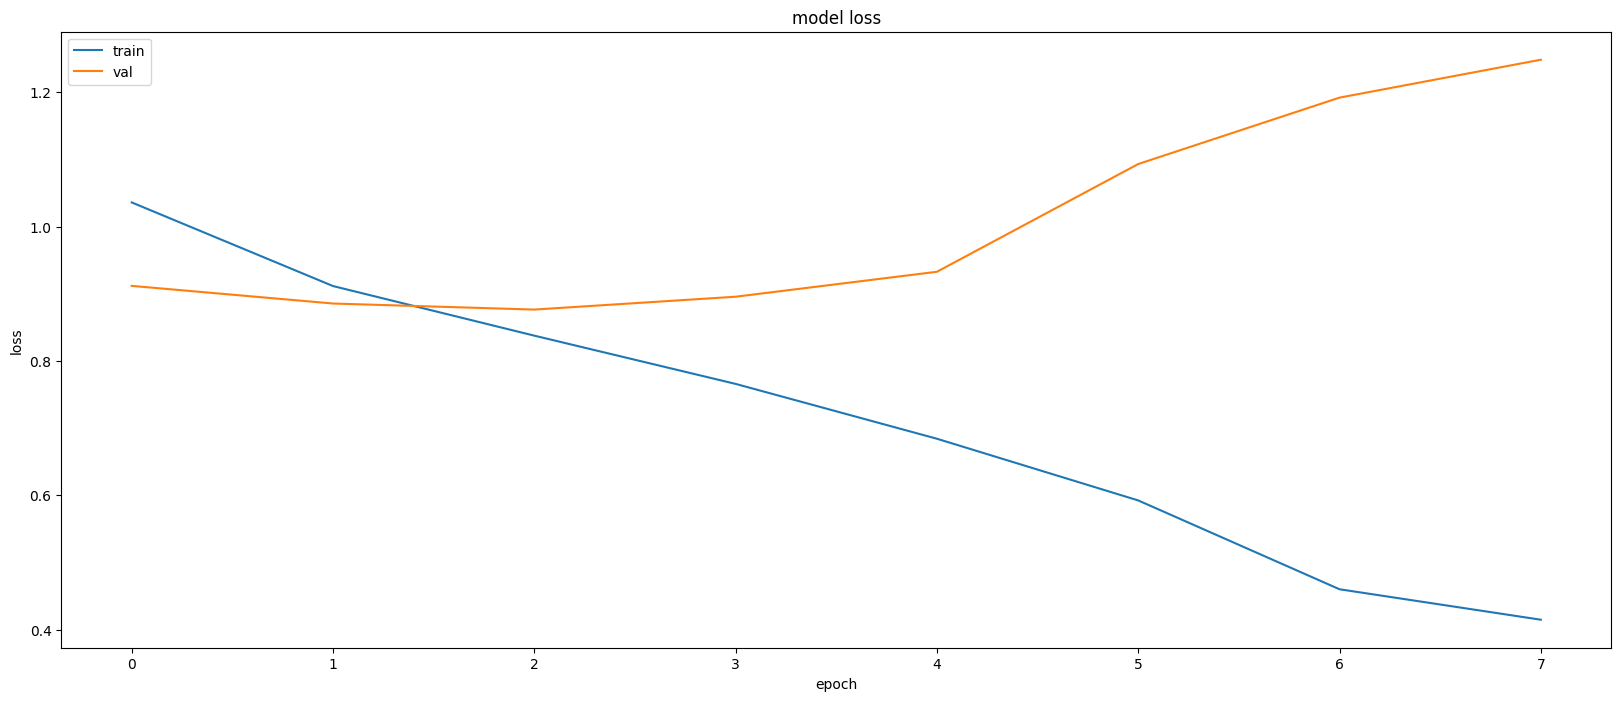

In [45]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

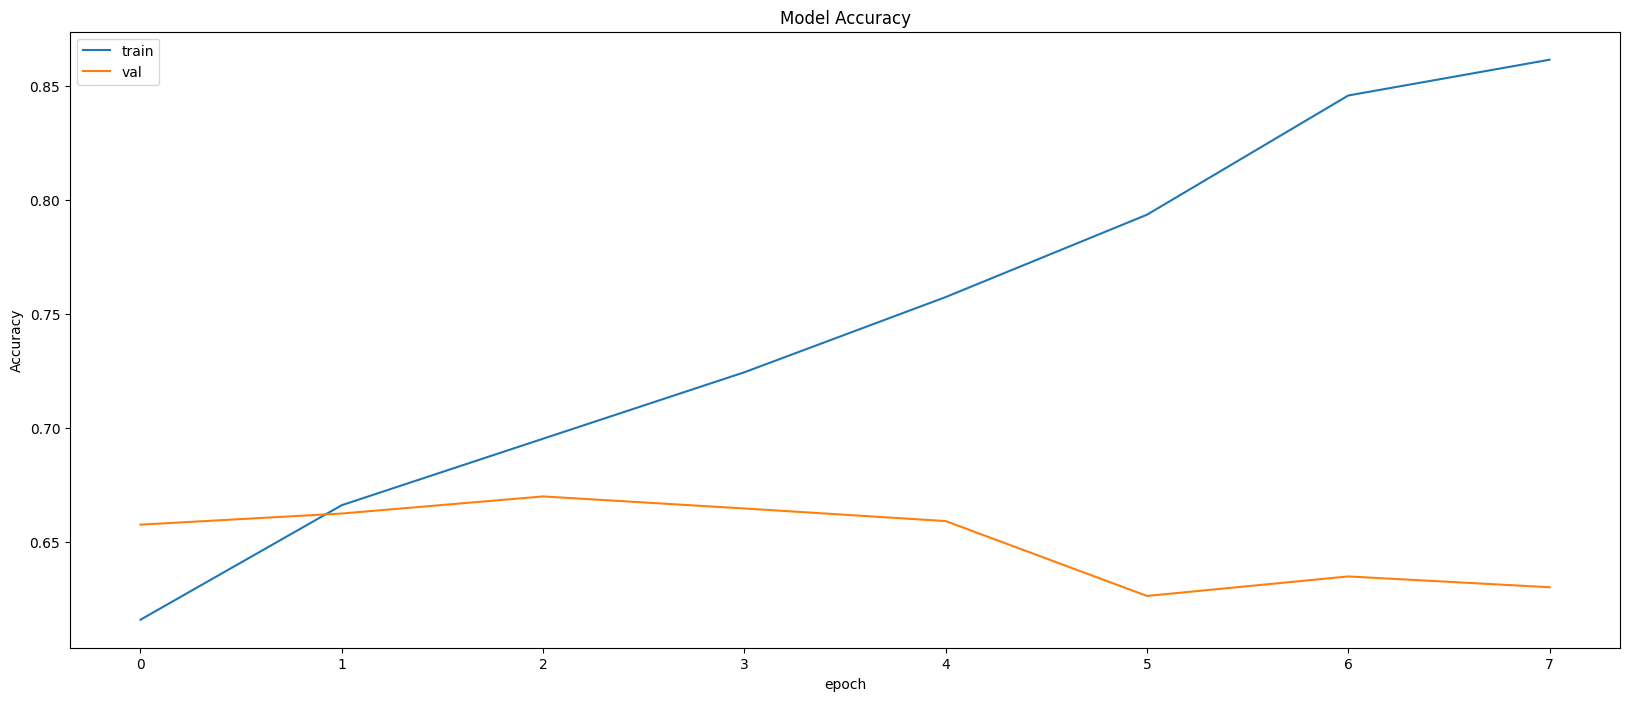

In [46]:
plt.figure(figsize=(20,8))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [47]:
y_pred_probs = model.predict((np.asarray(x_test['input_ids']),np.asarray(x_test['attention_masks'])))

2024-05-31 21:05:37.747408: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


439/439 [==============================] - 21s 26ms/step


In [48]:
y_pred = np.argmax(y_pred_probs, axis=1)

**Confusion Matrix**

In [49]:
!pip install seaborn
import seaborn as sns

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


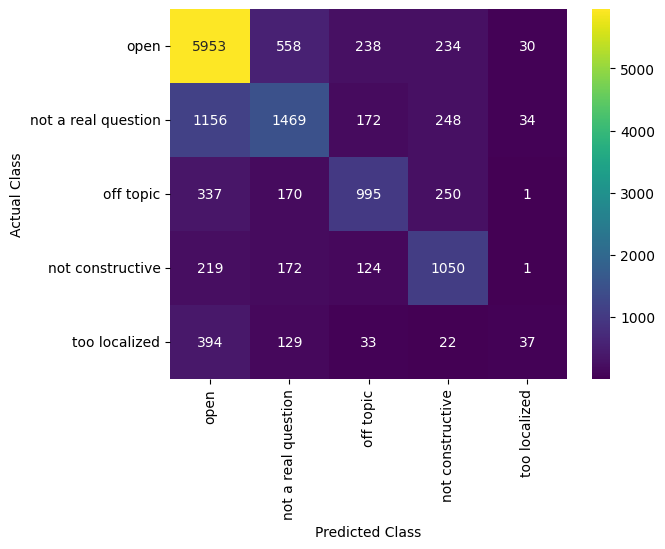

In [50]:
sns.heatmap(confusion_matrix(y_test, y_pred),cmap='viridis',annot=True,fmt='.5g',
            xticklabels=['open','not a real question','off topic','not constructive','too localized'],yticklabels=['open','not a real question','off topic','not constructive','too localized'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

In [51]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79      7013
           1       0.59      0.48      0.53      3079
           2       0.64      0.57      0.60      1753
           3       0.58      0.67      0.62      1566
           4       0.36      0.06      0.10       615

    accuracy                           0.68     14026
   macro avg       0.58      0.52      0.53     14026
weighted avg       0.66      0.68      0.66     14026

